In [1]:

import json
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
import pandas as pd


In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [3]:
TEXTFOLDER = "Dataset/img_txt/"
annotations = "Dataset/MMHS150K_GT.json"

In [4]:
with open(annotations) as json_file:
    data = json.load(json_file)

data_df = pd.DataFrame(data).T.reset_index()
data_df.rename(columns={'index':'id'},inplace=True)

In [5]:
data_df.tail()

,id,img_url,labels,tweet_url,tweet_text,labels_str
149818,1114170734472048640,http://pbs.twimg.com/tweet_video_thumb/D3ZUXNw...,"[2, 5, 0]",https://twitter.com/user/status/11141707344720...,@svdate @gtconway3d I would just say hes Donny...,"[Sexist, OtherHate, NotHate]"
149819,1110368198786846720,http://pbs.twimg.com/ext_tw_video_thumb/111036...,"[0, 0, 0]",https://twitter.com/user/status/11103681987868...,@Cheftime_Dev congrats my nigga keep on grindi...,"[NotHate, NotHate, NotHate]"
149820,1106941858540851200,http://pbs.twimg.com/media/D1yluGmXgAEKNG5.jpg,"[0, 1, 0]",https://twitter.com/user/status/11069418585408...,My nigga big shitty https://t.co/e0snJGBgH9,"[NotHate, Racist, NotHate]"
149821,1105268309233188865,http://pbs.twimg.com/tweet_video_thumb/D1azqiz...,"[1, 0, 0]",https://twitter.com/user/status/11052683092331...,did she just say “my nigga” to Rich? &amp; she...,"[Racist, NotHate, NotHate]"
149822,1114653514364530691,http://pbs.twimg.com/media/D3gLdL0W0AENzVJ.jpg,"[0, 0, 3]",https://twitter.com/user/status/11146535143645...,This nigga Joe Budden said thanos got a galact...,"[NotHate, NotHate, Homophobe]"


In [6]:
nameMapping = {
    0: 'Not Hate Speech',
    1 : 'Hate Speech'
}

In [7]:
def NewClass(cls):
    if cls in range(1,5):
        return 1
    elif cls == 0:
        return 0
    else:
        return 1
for tweetid , tweetData in data.items():
    cls = tweetData['labels']
    newClass = [NewClass(i) for i in cls]
    tweetData['combinedLabels'] = newClass
    tweetData['combinedLabels_str'] = nameMapping.get(newClass[0],'Unknown')    

In [8]:
data_df = pd.DataFrame(data).T.reset_index()
data_df.rename(columns={'index':'id'},inplace=True)

In [9]:
data_df['combinedLabels_str'].value_counts()

combinedLabels_str
Not Hate Speech    104598
Hate Speech         45225
Name: count, dtype: int64

In [10]:
combined_labels = [item for sublist in data_df['labels_str'] for item in sublist]

In [11]:
labels_val = [item for sublist in data_df['labels'] for item in sublist]

In [12]:
labels = set(combined_labels)

In [13]:
labels

{'Homophobe', 'NotHate', 'OtherHate', 'Racist', 'Religion', 'Sexist'}

In [14]:
print(f"{data_df['labels'].head(),data_df['labels_str'].head()}")

(0    [4, 1, 3]
1    [5, 5, 5]
2    [0, 0, 0]
3    [1, 0, 0]
4    [1, 0, 1]
Name: labels, dtype: object, 0        [Religion, Racist, Homophobe]
1    [OtherHate, OtherHate, OtherHate]
2          [NotHate, NotHate, NotHate]
3           [Racist, NotHate, NotHate]
4            [Racist, NotHate, Racist]
Name: labels_str, dtype: object)


In [15]:
labelVal = set(labels_val)
labelVal

{0, 1, 2, 3, 4, 5}

In [16]:
data_df.tail()

,id,img_url,labels,tweet_url,tweet_text,labels_str,combinedLabels,combinedLabels_str
149818,1114170734472048640,http://pbs.twimg.com/tweet_video_thumb/D3ZUXNw...,"[2, 5, 0]",https://twitter.com/user/status/11141707344720...,@svdate @gtconway3d I would just say hes Donny...,"[Sexist, OtherHate, NotHate]","[1, 1, 0]",Hate Speech
149819,1110368198786846720,http://pbs.twimg.com/ext_tw_video_thumb/111036...,"[0, 0, 0]",https://twitter.com/user/status/11103681987868...,@Cheftime_Dev congrats my nigga keep on grindi...,"[NotHate, NotHate, NotHate]","[0, 0, 0]",Not Hate Speech
149820,1106941858540851200,http://pbs.twimg.com/media/D1yluGmXgAEKNG5.jpg,"[0, 1, 0]",https://twitter.com/user/status/11069418585408...,My nigga big shitty https://t.co/e0snJGBgH9,"[NotHate, Racist, NotHate]","[0, 1, 0]",Not Hate Speech
149821,1105268309233188865,http://pbs.twimg.com/tweet_video_thumb/D1azqiz...,"[1, 0, 0]",https://twitter.com/user/status/11052683092331...,did she just say “my nigga” to Rich? &amp; she...,"[Racist, NotHate, NotHate]","[1, 0, 0]",Hate Speech
149822,1114653514364530691,http://pbs.twimg.com/media/D3gLdL0W0AENzVJ.jpg,"[0, 0, 3]",https://twitter.com/user/status/11146535143645...,This nigga Joe Budden said thanos got a galact...,"[NotHate, NotHate, Homophobe]","[0, 0, 1]",Not Hate Speech


In [17]:
train_df = pd.read_csv("E:/CapstoneProject/Dataset/splits/train_ids.txt",header = None)
train_df.columns = ['id']
test_df = pd.read_csv("E:/CapstoneProject/Dataset/splits/test_ids.txt",header = None)
test_df.columns = ['id']
valid_df = pd.read_csv("E:/CapstoneProject/Dataset/splits/val_ids.txt",header = None)
valid_df.columns = ['id']

In [18]:
train_df['text_path'] = TEXTFOLDER + train_df['id'].astype(str) + '.json'
valid_df['text_path'] = TEXTFOLDER + valid_df['id'].astype(str) + '.json'
test_df['text_path'] = TEXTFOLDER + test_df['id'].astype(str) + '.json'

In [19]:
train_df['id'] = train_df['id'].astype(str)
test_df['id'] = test_df['id'].astype(str)
valid_df['id'] = test_df['id'].astype(str)

In [20]:
data_df['id'] = data_df['id'].astype(str)

In [21]:
train_df = train_df.merge(data_df, on='id', how='left')
valid_df = valid_df.merge(data_df, on='id', how='left')
test_df = test_df.merge(data_df, on='id', how='left')

In [22]:
train_df['fileName'] = train_df['text_path'].str.split('/').apply(lambda a:a[-1])
test_df['fileName'] = test_df['text_path'].str.split('/').apply(lambda a:a[-1])

In [23]:
dir_files = os.listdir("E:/CapstoneProject/Dataset/img_txt")
train_df['filesAvailable'] = train_df['fileName'].apply(lambda x: x in dir_files)

In [24]:
train_df['filesAvailable'].value_counts()

filesAvailable
False    81667
True     53156
Name: count, dtype: int64

In [25]:
test_df['filesAvailable'] = test_df['fileName'].str.replace('img_txt','')
test_df['filesAvailable'] = test_df['fileName'].isin(os.listdir('E:/CapstoneProject/Dataset/img_txt'))

In [26]:
train_df = train_df[train_df['filesAvailable'] == True]

In [27]:
test_df = test_df[test_df['filesAvailable'] == True]

In [29]:
with open("Dataset/img_txt/1023940826882293760.json") as file:
    data = json.load(file)
text = data['img_text']
print(text)

import matplotlib.pyplot as plt
%matplotlib inline

def showText(path):
    try:
        with open(path) as file:
            data = json.load(file)
        text = data['img_text']
    except FileNotFoundError:
        text = "File Not found error"
    return text    

İ'M SLOWLY BEC«MİNG RETARpEp! 


In [30]:
train_df['labels'] = train_df['combinedLabels'].apply(lambda a : a[0])

test_df['labels'] = test_df['combinedLabels'].apply(lambda a : a[0])

train_df['labels'].unique()

train_df['text'] = train_df.apply(lambda x : showText(x['text_path']),axis = 1)

train_df['text']

0                                                a bunch c 
1                                     nericansForTruth.org 
2                                                CHEVROLET 
7         trixie as a cheerleader trixie a a- cheerleade...
9                                          CHELSEA HANDLER 
                                ...                        
134813    CONVICT VAND E WHOLE SYSTEM IS GU COOK COUNTY ...
134816    137 ctrijesssry SE WOT 105 120 150 ) x Relentl...
134817                      Justine Canilao 30 subscribers 
134818    VICTORY Ranked Solo/Duo W:40-L:4025:36 ADVANCE...
134822                                            快手 88877 
Name: text, Length: 53156, dtype: object

In [35]:
class TextDataset(Dataset):
    def __init__(self,df,text='text',labelsField = 'labels'):
        self.df = df.reset_index(drop = True)
        self.text = text
        self.labelsField = labelsField
    
    def __getitem__(self, index):
        text = self.df.at[index , self.text]
        labels = self.df.at[index , self.labelsField]
        return text , labels
    
    def __len__(self):
        return self.df.shape[0]
    
    
bertTokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        

In [44]:
class VLBertModel(nn.Module):
    def __init__(self, numLabels, preTrained = 'bert-base-uncased'):
        super().__init__()
        self.numLabels = numLabels
        self.text_encoder = AutoModel.from_pretrained(preTrained)
        self.classifier = nn.Linear(
            self.text_encoder.config.hidden_size,numLabels
        )
    def forward(self,text):
        output = self.text_encoder(text['input_ids'],attention_mask = text['attention_mask'] , return_dict = True)
        logits = self.classifier(output.last_hidden_state[:,0,:])
        return logits

out_labels = 2
train_epochs = 10
batch_size = 20
learning_rate = 0.0004
weight_decay = .01
warmup_steps = 0
max_seq_length =  64

bertModel = VLBertModel(numLabels=out_labels)

bertModel = bertModel.to(device)


In [36]:
train_dataset = TextDataset(df=train_df, text='tweet_text', labelsField='labels')
train_sampler = RandomSampler(train_dataset)        
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size, 
                    sampler=train_sampler)


t_total = len(train_dataloader) * train_epochs

In [40]:
optimizer = AdamW(bertModel.parameters(),lr = learning_rate,weight_decay=weight_decay)

scheduler = get_scheduler(name='cosine',optimizer=optimizer,num_warmup_steps=warmup_steps,num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

bertModel.train()

start = perf_counter()

for epoch_num in range(train_epochs):
    epch_total_loss = 0
    for step,batch in tqdm(enumerate(train_dataloader),total=len(train_dataloader)):
        batch_text , batch_labels = batch
        batch_inputs = bertTokenizer(
            list(batch_text),truncation = True,max_length = max_seq_length,
            return_tensors = "pt",padding = True
        )
        batch_labels = batch_labels.to(device)
        batch_inputs = batch_inputs.to(device)
        bertModel.zero_grad()
        batch_logits = bertModel(text = batch_inputs)
        loss = criterion(batch_logits,batch_labels)
        epch_total_loss += loss.item()
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
    avgLoss = epch_total_loss/len(train_dataloader)
    print('epoch =',epoch_num)
    print('epoch Loss =',epch_total_loss)
    print('avg Loss ', avgLoss)
    print('learning rate',optimizer.param_groups[0]["lr"])
end = perf_counter()
bertTrainingRate = end - start 
print("Training Completed in ", bertTrainingRate)


  0%|          | 0/2658 [00:00<?, ?it/s]

epoch = 0
epoch Loss = 1632.4456431865692
avg Loss  0.6141631464208311
learning rate 0.00039021130325903074


  0%|          | 0/2658 [00:00<?, ?it/s]

epoch = 1
epoch Loss = 1618.6918658018112
avg Loss  0.6089886628298763
learning rate 0.0003618033988749895


  0%|          | 0/2658 [00:00<?, ?it/s]

epoch = 2
epoch Loss = 1615.9704299867153
avg Loss  0.6079647968347311
learning rate 0.00031755705045849464


  0%|          | 0/2658 [00:00<?, ?it/s]

epoch = 3
epoch Loss = 1614.6914428174496
avg Loss  0.6074836127981376
learning rate 0.00026180339887498953


  0%|          | 0/2658 [00:00<?, ?it/s]

epoch = 4
epoch Loss = 1614.4024878442287
avg Loss  0.6073749013710417
learning rate 0.0002


  0%|          | 0/2658 [00:00<?, ?it/s]

epoch = 5
epoch Loss = 1613.663670629263
avg Loss  0.6070969415459981
learning rate 0.00013819660112501054


  0%|          | 0/2658 [00:00<?, ?it/s]

epoch = 6
epoch Loss = 1613.3641338944435
avg Loss  0.6069842490197305
learning rate 8.24429495415054e-05


  0%|          | 0/2658 [00:00<?, ?it/s]

epoch = 7
epoch Loss = 1612.8481405675411
avg Loss  0.6067901206047935
learning rate 3.819660112501053e-05


  0%|          | 0/2658 [00:00<?, ?it/s]

epoch = 8
epoch Loss = 1612.5957716107368
avg Loss  0.6066951736684488
learning rate 9.788696740969295e-06


  0%|          | 0/2658 [00:00<?, ?it/s]

epoch = 9
epoch Loss = 1612.5637193620205
avg Loss  0.6066831148841311
learning rate 0.0
Training Completed in  9760.3957162


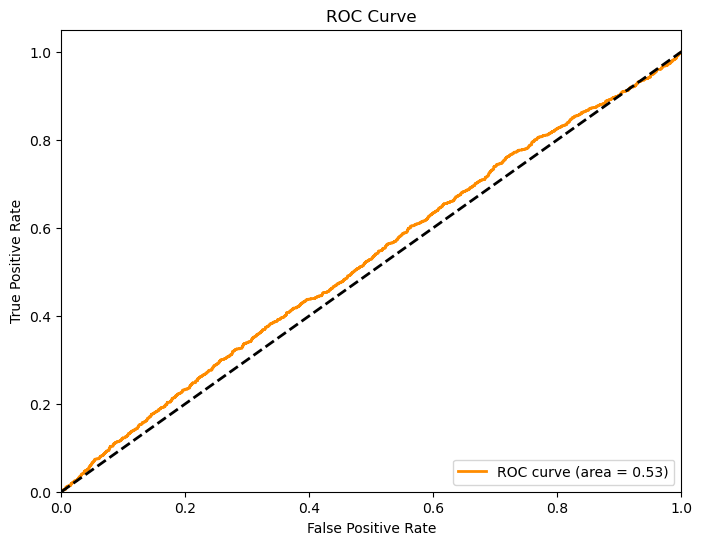

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# If bert_prediction_probs is (N, 1), flatten it
if bert_prediction_probs.shape[1] == 1:
    y_score = bert_prediction_probs.ravel()
else:
    y_score = bert_prediction_probs[:, 1]  # Use positive class

# Binarize the labels
y_true = (test_df['labels'] == 1).astype(int).values

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [46]:
bertModel.eval()
bert_prediction_probs = []
with torch.no_grad():
    for text, _ in DataLoader(TextDataset(test_df, text='tweet_text', labelsField='labels'), batch_size=32):
        inputs = bertTokenizer(list(text), truncation=True, max_length=64, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        logits = bertModel(text=inputs)
        probs = torch.softmax(logits, dim=1)
        bert_prediction_probs.append(probs.cpu().numpy())
bert_prediction_probs = np.concatenate(bert_prediction_probs, axis=0)